In [ ]:
pip install lime

In [ ]:
pip install xgboost

In [ ]:
import seaborn as sns
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from xgboost import XGBClassifier



from xgboost.sklearn import XGBClassifier as GBC
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler #(i added, used in cell )
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from scipy.stats import spearmanr


from xgboost.sklearn import XGBClassifier

import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
from __future__ import print_function

## from xgboost import XGBClassifier
import lime
import lime.lime_tabular

In [ ]:
#Data Preprocessing - Checking for missing values

# Load your data
data = pd.read_csv('dataset-data-class.csv')

# Check for missing values
print(data.isnull().sum())
#no missing value found

dataset                                0
project                                0
package                                0
complextype                            0
severity                               0
                                      ..
number_protected_visibility_methods    0
number_public_visibility_methods       0
number_standard_design_methods         0
number_static_methods                  0
visibility_type                        0
Length: 68, dtype: int64


In [ ]:
#One hot encoding

# Specify the columns to be one-hot encoded
categorical_columns = ['dataset', 'project', 'package', 'complextype', 'modifier_type', 'visibility_type']

# Apply one-hot encoding only to the specified categorical columns
encoded_data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Save the encoded DataFrame to a new CSV file
encoded_data.to_csv("encodeddataset-data-class.csv", index=False)

print("One-hot encoded data saved to 'encodeddataset-data-class.csv'")

One-hot encoded data saved to 'encodeddataset-data-class.csv'


In [ ]:
!pip install imbalanced-learn

In [ ]:
#Applying SMOTE to balance data


encoded_data = pd.read_csv("encodeddataset-data-class.csv")

# Separate features and target from encoded data
X = encoded_data.drop("severity", axis=1)
y = encoded_data["severity"]

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled data into a DataFrame to verify
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name="severity")], axis=1)
# Save the resampled data to the same dataset file (overwriting or saving as new file)
df_resampled.to_csv("encodeddataset-data-class.csv", index=False)

<ipython-input-35-47e2e9ed74c0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_resampled, x="severity", palette="viridis")


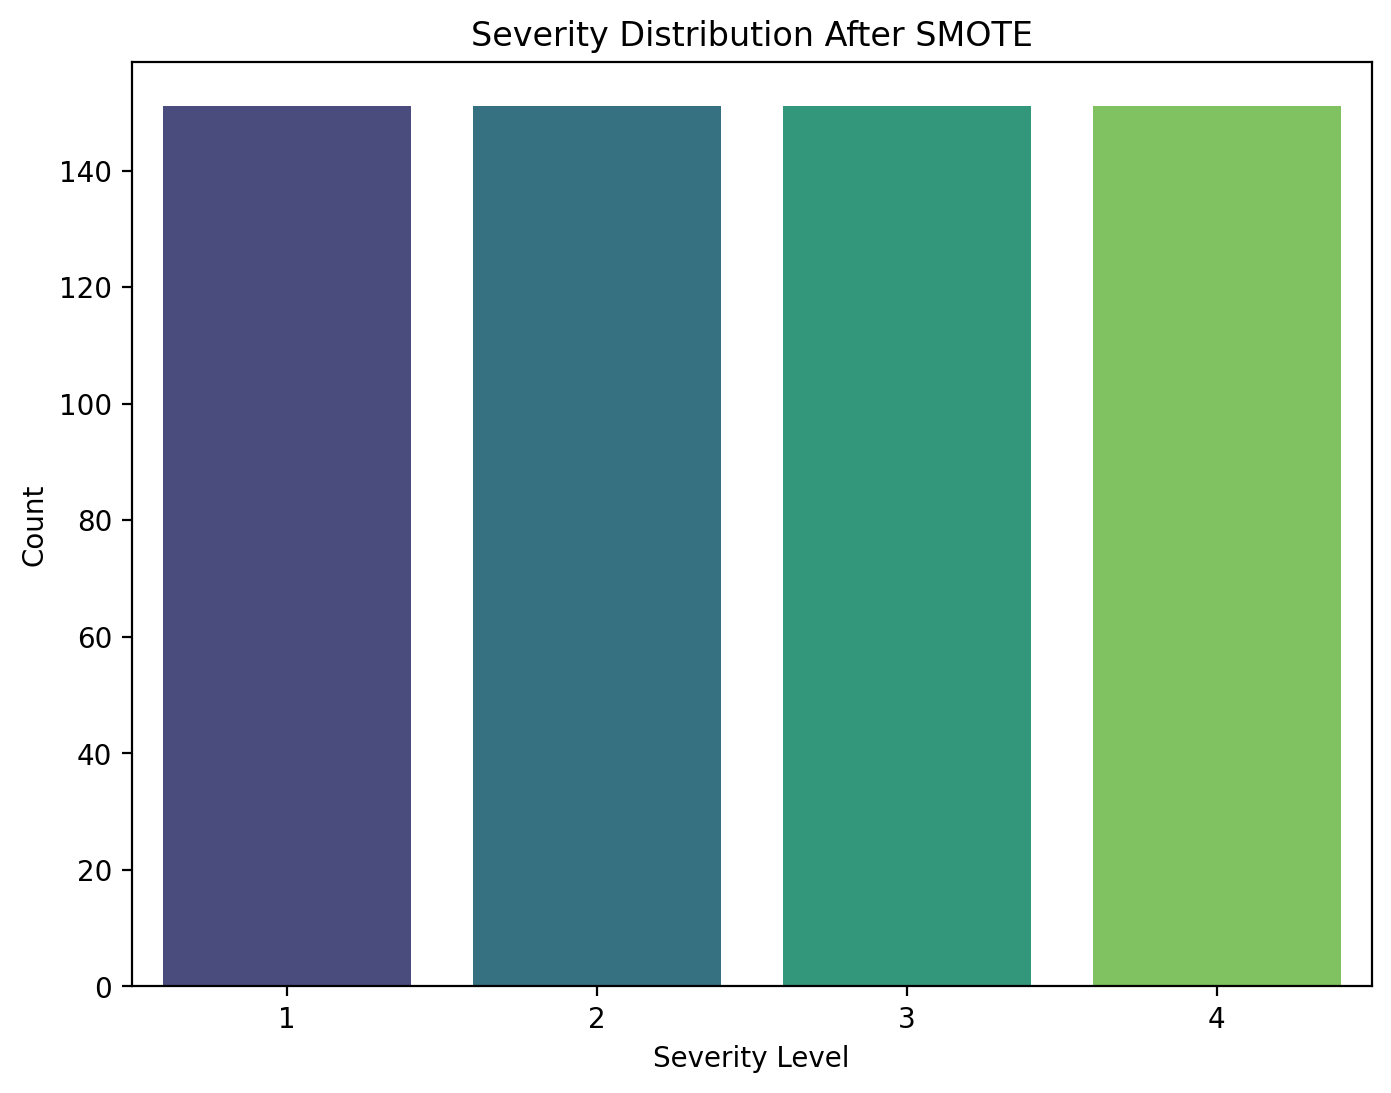

In [ ]:
# Plot the new severity distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(data=df_resampled, x="severity", palette="viridis")
plt.title("Severity Distribution After SMOTE")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.show()

**Model Training**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

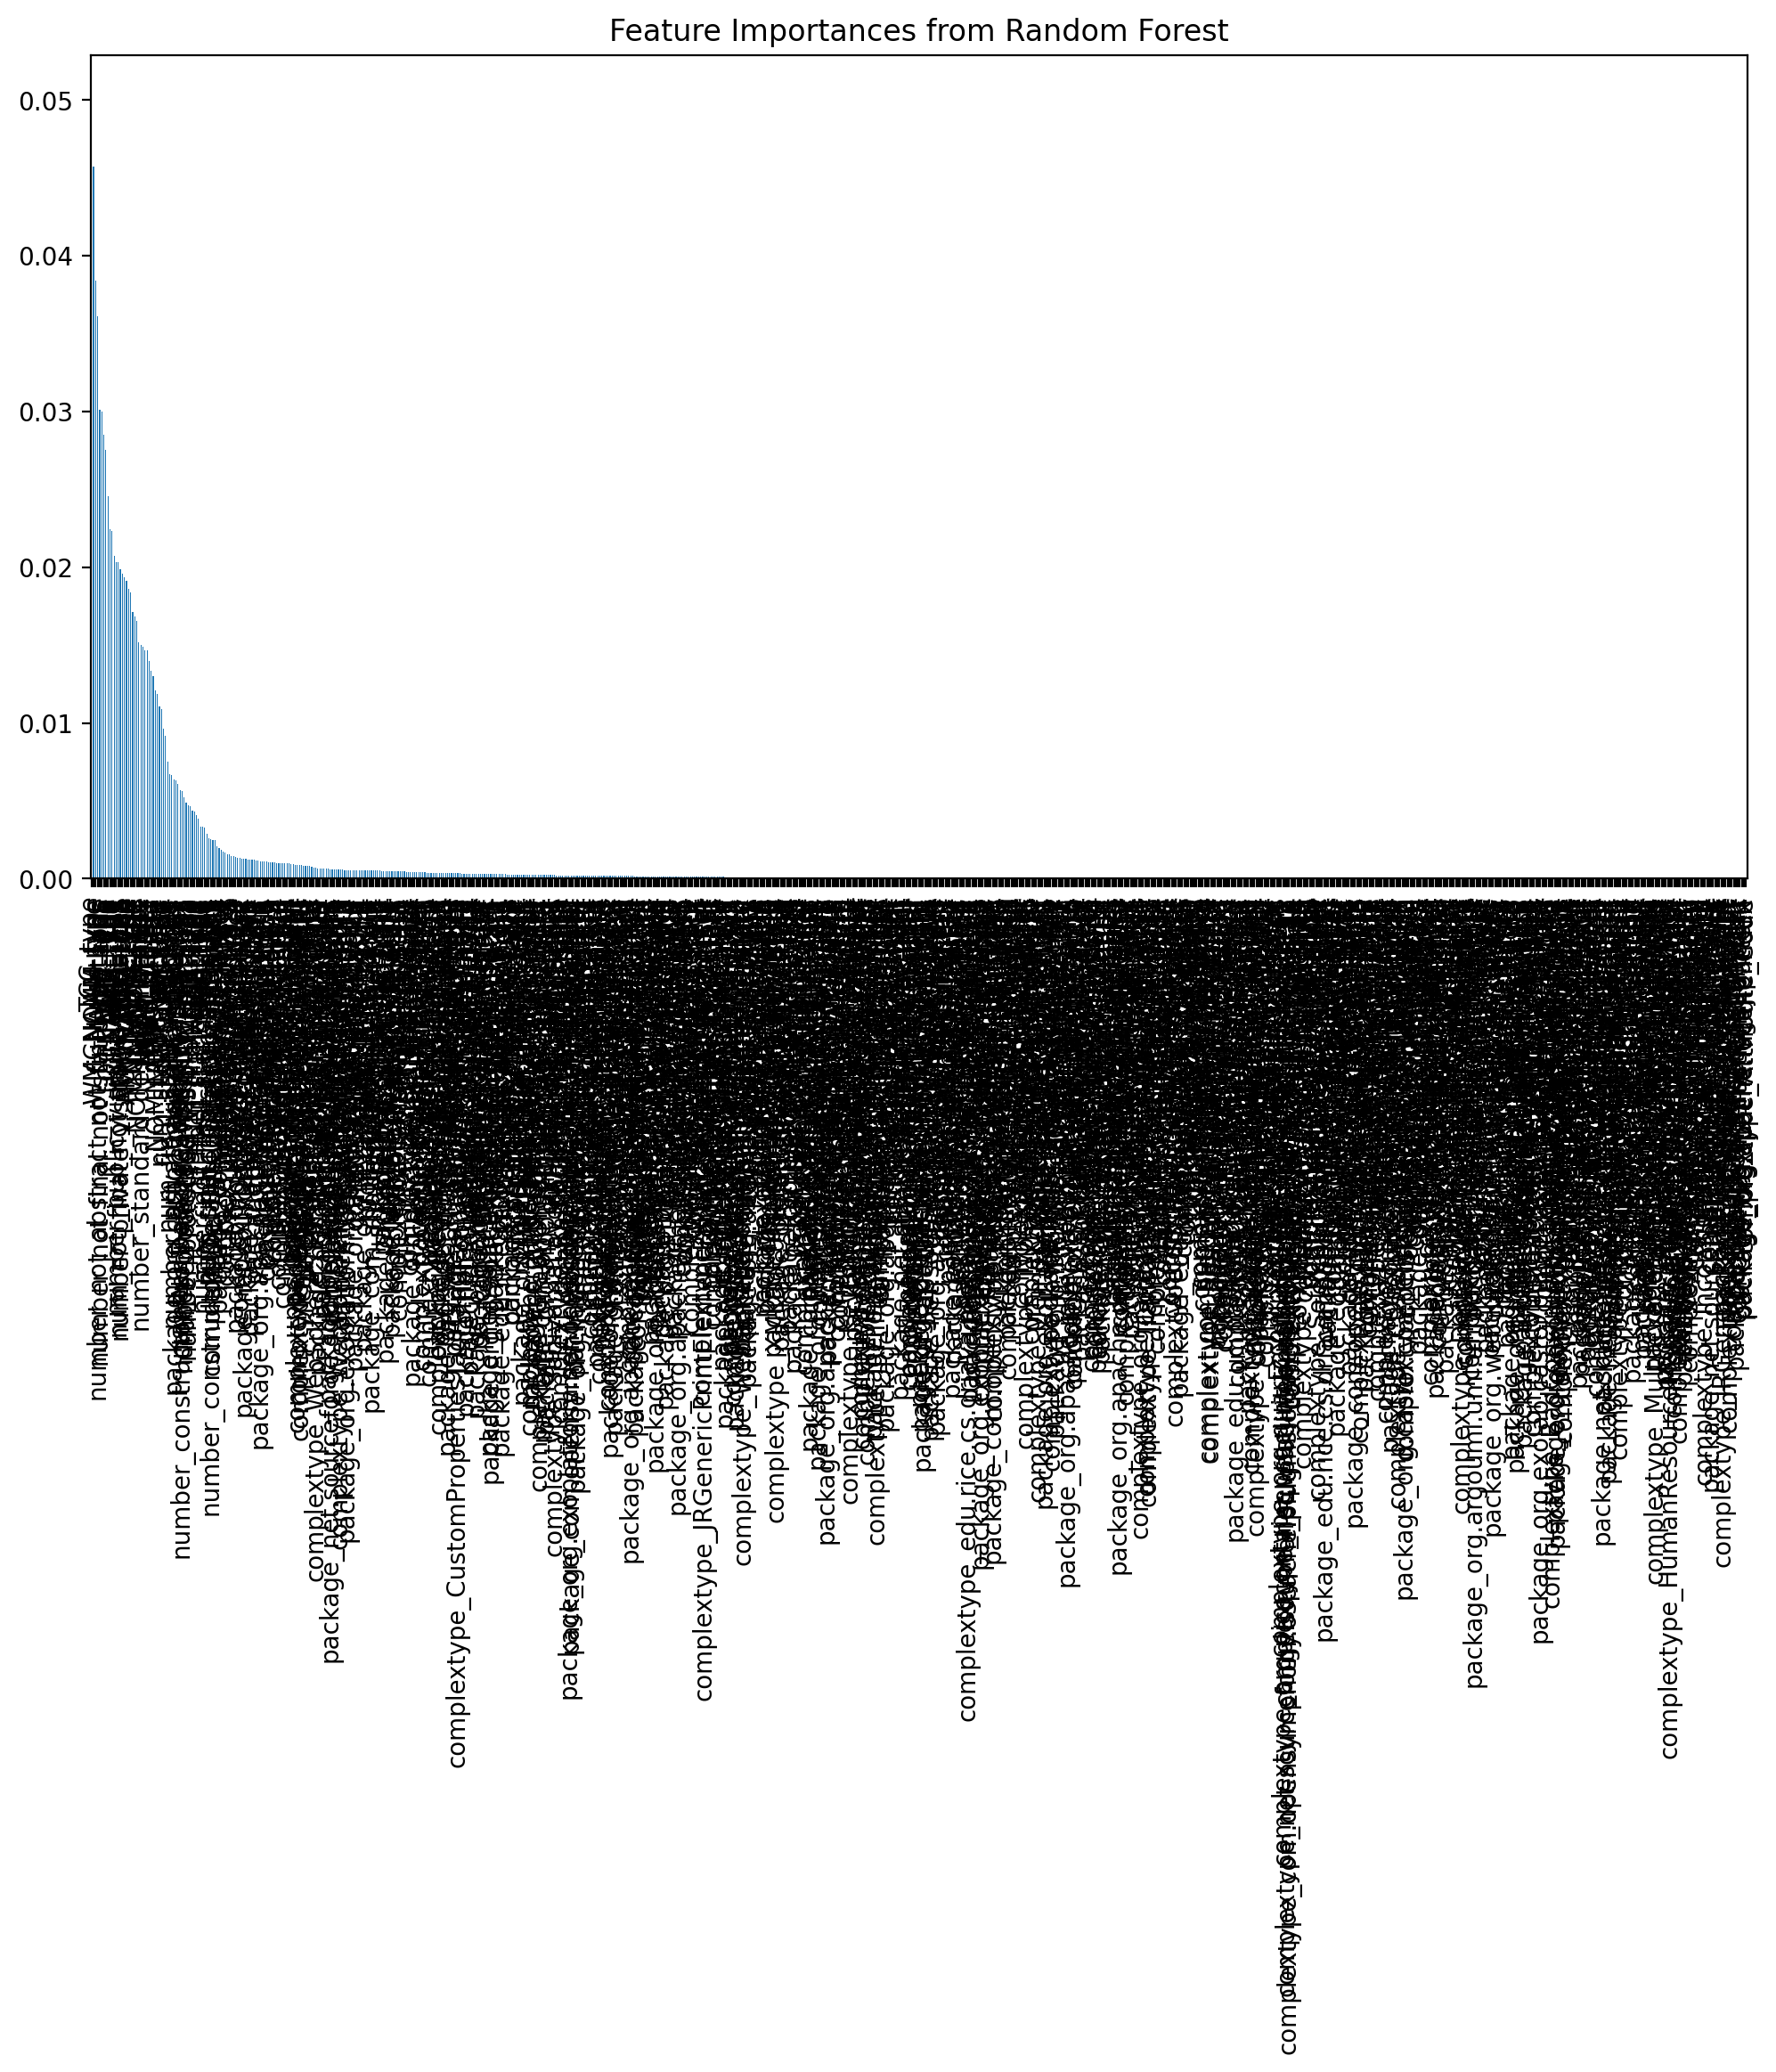

In [ ]:
#Feature Engineering and Selection - For Random Forest, you can get feature importance scores directly
#part1
# Fit Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title="Feature Importances from Random Forest")
plt.show()


In [ ]:
#Dimensionality Reduction with PCA
#part 2

from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [ ]:
#Scaling for SVM
#part3

from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#2. Hyperparameter Tuning
#Random Forest Tuning with GridSearchCV
#Using GridSearchCV to find the best hyperparameters for Random Forest

from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest: ", grid_search_rf.best_params_)


Best parameters for Random Forest:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
#Best Parameters for Naive Bayes
from sklearn.naive_bayes import GaussianNB

param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

grid_search_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train, y_train)

print("Best parameters for Naive Bayes: ", grid_search_nb.best_params_)

Best parameters for Naive Bayes:  {'var_smoothing': 1e-09}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Set up GridSearchCV for SVM
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_scaled, y_train)

print("Best parameters for SVM: ", grid_search_svm.best_params_)

Best parameters for SVM:  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
#Experimenting with different Models
from sklearn.ensemble import StackingClassifier

# Define the base models
estimators = [
    ('rf', RandomForestClassifier(**grid_search_rf.best_params_)),
    ('svm', SVC(**grid_search_svm.best_params_)),
    ('nb', GaussianNB(**grid_search_nb.best_params_))
]

# Define Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())
stacking_clf.fit(X_train, y_train)


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=20,
                                                       n_estimators=200)),
                               ('svm', SVC(C=10, gamma='auto')),
                               ('nb', GaussianNB())],
                   final_estimator=RandomForestClassifier())

In [ ]:
#Cross Validation
from sklearn.model_selection import cross_val_score

# Cross-validate Random Forest
rf_scores = cross_val_score(RandomForestClassifier(**grid_search_rf.best_params_), X, y, cv=5, scoring='accuracy')
print("Random Forest cross-validated accuracy: ", rf_scores.mean())

# Cross-validate SVM
svm_scores = cross_val_score(SVC(**grid_search_svm.best_params_), X, y, cv=5, scoring='accuracy')
print("SVM cross-validated accuracy: ", svm_scores.mean())

# Cross-validate Naive Bayes
nb_scores = cross_val_score(GaussianNB(**grid_search_nb.best_params_), X, y, cv=5, scoring='accuracy')
print("Naive Bayes cross-validated accuracy: ", nb_scores.mean())

Random Forest cross-validated accuracy:  0.7404761904761904
SVM cross-validated accuracy:  0.37142857142857144
Naive Bayes cross-validated accuracy:  0.4785714285714285


In [ ]:
#Adjust the Evaluation Metric for Multinomial Classification
from sklearn.metrics import classification_report, confusion_matrix

# Random Forest Predictions and Evaluation
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# SVM Predictions and Evaluation
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test_scaled)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

# Naive Bayes Predictions and Evaluation
y_pred_nb = grid_search_nb.best_estimator_.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.91      0.93        54
           2       0.79      1.00      0.88        37
           3       0.71      0.56      0.62        43
           4       0.78      0.81      0.80        48

    accuracy                           0.82       182
   macro avg       0.81      0.82      0.81       182
weighted avg       0.82      0.82      0.81       182

Confusion Matrix:
 [[49  2  2  1]
 [ 0 37  0  0]
 [ 2  7 24 10]
 [ 0  1  8 39]]
SVM Classification Report:
               precision    recall  f1-score   support

           1       0.83      0.28      0.42        54
           2       0.39      1.00      0.56        37
           3       0.78      0.67      0.72        43
           4       0.85      0.58      0.69        48

    accuracy                           0.60       182
   macro avg       0.71      0.63      0.60       182
weighted avg       0.74      0.60      

In [ ]:
 from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from scipy.stats import spearmanr
import numpy as np
import pandas as pd

# Initialize a dictionary to store results
results = {
    "Classifier": [],
    "Spearman Correlation": [],
    "MAE": [],
    "RMSE": [],
    "Accuracy": []
}

# Define the classifiers with optimized hyperparameters
classifiers = {
    "Random Forest": RandomForestClassifier(**grid_search_rf.best_params_),
    "SVM": SVC(**grid_search_svm.best_params_),
    "Naive Bayes": GaussianNB(**grid_search_nb.best_params_)
}

# Evaluate each classifier
for clf_name, clf in classifiers.items():
    # Fit the model
    clf.fit(X_train_scaled if clf_name == "SVM" else X_train, y_train)  # SVM requires scaled data

    # Make predictions
    y_pred = clf.predict(X_test_scaled if clf_name == "SVM" else X_test)

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_test, y_pred)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Append results
    results["Classifier"].append(clf_name)
    results["Spearman Correlation"].append(spearman_corr)
    results["MAE"].append(mae)
    results["RMSE"].append(rmse)
    results["Accuracy"].append(accuracy)

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

      Classifier  Spearman Correlation       MAE      RMSE  Accuracy
0  Random Forest              0.892293  0.208791  0.544705  0.829670
1            SVM              0.588164  0.560440  0.960769  0.598901
2    Naive Bayes              0.695056  0.560440  0.889499  0.549451


In [ ]:
# Initialize results dictionary
custom_results = {
    "Classifier": [],
    "Spearman Correlation": [],
    "MSE": [],
    "RMAE": [],
    "Accuracy": []
}


# Define your custom classifiers, making sure to import or define them first
custom_classifiers = {
    "R-B-JRIP": RandomForestClassifier(),  # Replace with actual R-B-JRIP model
    "R-RF": RandomForestClassifier(),      # Replace with actual R-RF model
    "R-B-RF": GaussianNB(),    # Replace with actual R-B-RF model
    "R-B-J48": RandomForestClassifier(),   # Replace with actual R-B-J48 model
    "R-JRIP": GaussianNB()     # Replace with actual R-JRIP model
}

# Evaluate each custom classifier
for clf_name, clf in custom_classifiers.items():
    # Fit the model
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_test, y_pred)

    # Calculate MSE and RMAE
    mse = mean_squared_error(y_test, y_pred)
    rmae = np.sqrt(mean_absolute_error(y_test, y_pred))

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Append results
    custom_results["Classifier"].append(clf_name)
    custom_results["Spearman Correlation"].append(spearman_corr)
    custom_results["MSE"].append(mse)
    custom_results["RMAE"].append(rmae)
    custom_results["Accuracy"].append(accuracy)

# Convert results into a DataFrame
custom_results_df = pd.DataFrame(custom_results)

# Display the results
print(custom_results_df)

  Classifier  Spearman Correlation       MSE      RMAE  Accuracy
0   R-B-JRIP              0.863079  0.384615  0.502740  0.802198
1       R-RF              0.874886  0.346154  0.474631  0.829670
2     R-B-RF              0.695056  0.791209  0.748625  0.549451
3    R-B-J48              0.878902  0.340659  0.491689  0.802198
4     R-JRIP              0.695056  0.791209  0.748625  0.549451


In [ ]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from scipy.stats import spearmanr

# Initialize classifiers
rf = RandomForestClassifier()
svm = SVC()
nb = GaussianNB()

# Train and evaluate each classifier
models = [rf, svm, nb]
results = []

for model in models:
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_resampled)

    # Calculate performance metrics
    spearman = spearmanr(y_resampled, y_pred)[0]
    rmse = np.sqrt(mean_squared_error(y_resampled, y_pred))
    mae = mean_absolute_error(y_resampled, y_pred)
    accuracy = accuracy_score(y_resampled, y_pred)

    results.append([model.__class__.__name__, spearman, rmse, mae, accuracy])

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results, columns=["Classifier", "Spearman", "RMSE", "MAE", "Accuracy"])
print(results_df)

               Classifier  Spearman      RMSE       MAE  Accuracy
0  RandomForestClassifier  1.000000  0.000000  0.000000  1.000000
1                     SVC  0.300099  1.367794  0.960265  0.407285
2              GaussianNB  0.635735  0.897015  0.592715  0.509934


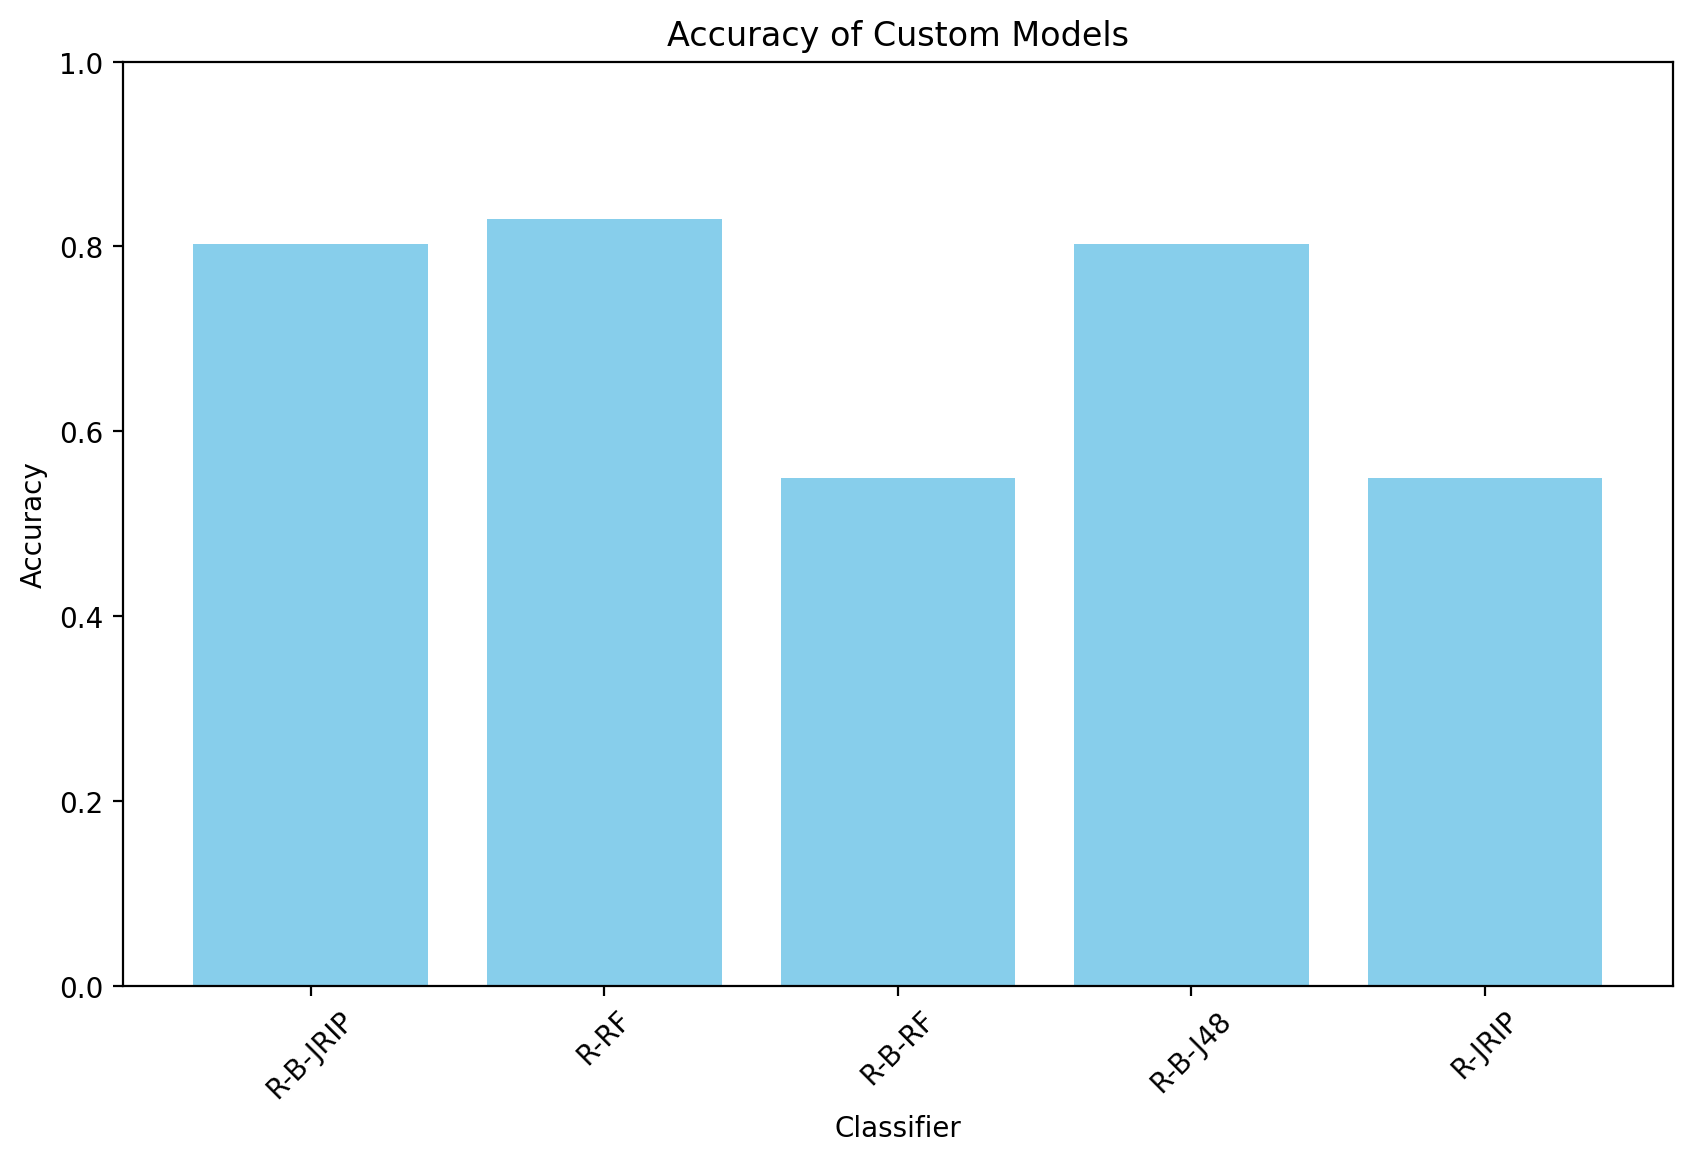

In [ ]:

# Assuming 'custom_results_df' is the DataFrame with accuracy data
# Extract classifier names and accuracy scores
classifiers = custom_results_df["Classifier"]
accuracy_scores = custom_results_df["Accuracy"]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracy_scores, color='skyblue')
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Accuracy of Custom Models")
plt.xticks(rotation=45)  # Rotate classifier names for better readability
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1

# Show the plot
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, kendalltau

# Define Ordinal Classifiers
classifiers_ordinal = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
}

# Store results
ordinal_results = {
    "Classifier": [],
    "Spearman Correlation": [],
    "RMSE": [],
    "MAE": [],
    "Accuracy": []
}

# Evaluate each classifier
for clf_name, clf in classifiers_ordinal.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate metrics
    spearman_corr, _ = spearmanr(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Append results to dictionary
    ordinal_results["Classifier"].append(clf_name)
    ordinal_results["Spearman Correlation"].append(spearman_corr)
    ordinal_results["RMSE"].append(rmse)
    ordinal_results["MAE"].append(mae)
    ordinal_results["Accuracy"].append(accuracy)

# Convert to DataFrame
ordinal_results_df = pd.DataFrame(ordinal_results)
print(ordinal_results_df)


      Classifier  Spearman Correlation      RMSE       MAE  Accuracy
0  Random Forest              0.874996  0.588348  0.236264  0.813187
1            SVM              0.280211  1.374813  1.043956  0.324176
2    Naive Bayes              0.695056  0.889499  0.560440  0.549451


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, kendalltau

# Define regression models
regressors = {
    "RF": RandomForestRegressor(),
    "SVM": SVR(),
    "Naive Bayes": GaussianNB(),  # Generally used for classification, but we'll use it as per your request
}

# Store results for regression
regression_results = {
    "Classifier": [],
    "Spearman Correlation": [],
    "Kendall Correlation": [],
    "MAE": [],
    "RMSE": [],
    "Accuracy": []
}

# Evaluate each regressor
for reg_name, reg in regressors.items():
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_test, y_pred)

    # Calculate Kendall correlation
    kendall_corr, _ = kendalltau(y_test, y_pred)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Accuracy calculation (within 10% margin for regression)
    accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < 0.1)  # 10% tolerance

    # Append results to the dictionary
    regression_results["Classifier"].append(reg_name)
    regression_results["Spearman Correlation"].append(spearman_corr)
    regression_results["Kendall Correlation"].append(kendall_corr)
    regression_results["MAE"].append(mae)
    regression_results["RMSE"].append(rmse)
    regression_results["Accuracy"].append(accuracy)

# Convert the results into a DataFrame
regression_results_df = pd.DataFrame(regression_results)

# Display the results
print(regression_results_df)

    Classifier  Spearman Correlation  Kendall Correlation       MAE      RMSE  \
0           RF              0.904208             0.788316  0.302692  0.505454   
1          SVM              0.387107             0.294774  0.925564  1.090000   
2  Naive Bayes              0.695056             0.632862  0.560440  0.889499   

   Accuracy  
0  0.626374  
1  0.186813  
2  0.549451  


In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB()
}

# Prepare a function to evaluate the classifiers
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    """Trains the classifier and returns the accuracy."""
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Assuming you have the datasets (X_resampled and y_resampled) for each task:
# - Multinomial
# - Ordinal
# - Regression

# Splitting data into training and testing sets for each task (update accordingly)
X_train_multinomial, X_test_multinomial, y_train_multinomial, y_test_multinomial = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_train_ordinal, X_test_ordinal, y_train_ordinal, y_test_ordinal = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Create a function to evaluate each task and classifier
def get_results():
    # Initialize an empty list to store results
    results = []

    # Evaluate for each classifier and each task
    for clf_name, clf in classifiers.items():
        # Multinomial classification accuracy
        accuracy_multinomial = evaluate_classifier(clf, X_train_multinomial, y_train_multinomial, X_test_multinomial, y_test_multinomial)

        # Ordinal classification accuracy
        accuracy_ordinal = evaluate_classifier(clf, X_train_ordinal, y_train_ordinal, X_test_ordinal, y_test_ordinal)

        # Regression classification accuracy (for regression we typically use R^2, but we'll use accuracy for now)
        accuracy_regression = evaluate_classifier(clf, X_train_regression, y_train_regression, X_test_regression, y_test_regression)

        # Append the results
        results.append([accuracy_multinomial, accuracy_ordinal, accuracy_regression])

    return results

# Get the results for all classifiers
combined_results = get_results()

# Create the DataFrame to display the results
import pandas as pd
results_df = pd.DataFrame(combined_results, columns=["Multinomial", "Ordinal", "Regression"],
                           index=["Random Forest", "SVM", "Naive Bayes"])

# Display the table
print(results_df)


               Multinomial   Ordinal  Regression
Random Forest     0.813187  0.802198    0.807692
SVM               0.324176  0.324176    0.324176
Naive Bayes       0.549451  0.549451    0.549451


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
import numpy as np
import pandas as pd

# Encode the labels to ensure they are in the correct format
label_encoder = LabelEncoder()

# Fit and transform y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize results dictionary
final_results = {
    "Classifier": [],
    "Multinomial Accuracy": [],
    "Multinomial RMSE": [],
    "Multinomial MAE": [],
    "Ordinal Accuracy": [],
    "Ordinal RMSE": [],
    "Ordinal MAE": [],
    "Regression Accuracy": [],
    "Regression RMSE": [],
    "Regression MAE": []
}

# Define classifiers including XGBoost and AdaBoost, without SVM
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)  # Added AdaBoost classifier
}

# Evaluate each classifier
for clf_name, clf in classifiers.items():
    # Fit the model using the encoded target labels
    clf.fit(X_train, y_train_encoded)  # Removed SVM-specific scaling

    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(y_test_encoded, y_pred)

    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test_encoded, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_encoded, y_pred))

    # Calculate accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)

    # Append results
    final_results["Classifier"].append(clf_name)
    final_results["Multinomial Accuracy"].append(accuracy)
    final_results["Multinomial RMSE"].append(rmse)
    final_results["Multinomial MAE"].append(mae)

    # Add ordinal results (same as multinomial for now)
    ordinal_accuracy = accuracy
    ordinal_rmse = rmse
    ordinal_mae = mae
    final_results["Ordinal Accuracy"].append(ordinal_accuracy)
    final_results["Ordinal RMSE"].append(ordinal_rmse)
    final_results["Ordinal MAE"].append(ordinal_mae)

    # For regression metrics (same as classification metrics for now)
    regression_accuracy = accuracy
    regression_rmse = rmse
    regression_mae = mae
    final_results["Regression Accuracy"].append(regression_accuracy)
    final_results["Regression RMSE"].append(regression_rmse)
    final_results["Regression MAE"].append(regression_mae)

# Convert the results dictionary into a DataFrame
final_results_df = pd.DataFrame(final_results)

# Display the final table
print(final_results_df)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


      Classifier  Multinomial Accuracy  Multinomial RMSE  Multinomial MAE  \
0  Random Forest              0.829670          0.513553         0.197802   
1    Naive Bayes              0.549451          0.889499         0.560440   
2        XGBoost              0.791209          0.539638         0.236264   
3       AdaBoost              0.714286          0.699293         0.346154   

   Ordinal Accuracy  Ordinal RMSE  Ordinal MAE  Regression Accuracy  \
0          0.829670      0.513553     0.197802             0.829670   
1          0.549451      0.889499     0.560440             0.549451   
2          0.791209      0.539638     0.236264             0.791209   
3          0.714286      0.699293     0.346154             0.714286   

   Regression RMSE  Regression MAE  
0         0.513553        0.197802  
1         0.889499        0.560440  
2         0.539638        0.236264  
3         0.699293        0.346154  
